<a href="https://www.kaggle.com/code/robustus/whpa-get-started?scriptVersionId=96981897" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Wellhead Protection Area (WHPA) prediction #

Author: Robin Thibaut, Ghent University.
Date: 29/05/2022

This is a multivariate regression problem.

This dataset was created as part of the following study, which was published in the Journal of Hydrology: A new framework for experimental design using Bayesian Evidential Learning: the case of wellhead protection area [doi.org/10.1016/j.jhydrol.2021.126903](https://doi.org/10.1016/j.jhydrol.2021.126903).

The pre-print is available on arXiv: [arxiv.org/pdf/2105.05539.pdf](https://arxiv.org/pdf/2105.05539.pdf)

### Introduction ###
The Wellhead Protection Area (WHPA) is a zone around a pumping well where human activities are limited in order to preserve water resources, usually based on how long dangerous chemicals in the area will take to reach the pumping well (according to local regulation). The flow velocity in the subsurface around the well determines it, and it can be computed numerically using particle tracking or transport simulation, or in practice using tracer testing. A groundwater model is typically calibrated against field data before being used to calculate the WHPA. In highly populated places where land occupation is a big concern, the introduction of such zones could have a large socioeconomic impact.

### WHPA prediction ###
Different tracers emerge from six data sources (injection wells) scattered across the pumping well. Their job is to inject individual tracers into the system in order to predict their transport and record their breakthrough curves (BCs) at the pumping well location.
Numerous particles are artificially positioned around the pumping well, and their origins are traced backward in time to identify the associated WHPA.

Our predictor and target were generated using the USGS' open-source finite-difference code Modflow. To get different sets of predictors and targets, we ran different hydrologic models with one variable parameter, namely hydraulic conductivity in metres per day. To obtain a satisfactory heterogeneity in the hydraulic conductivity fields, which control the shape and extent of our target, the PAs, we used sequential gaussian simulation based on arbitrarily defined variograms. The pumping well is located at the 1000, 500 metres mark and is surrounded by six injection wells.

### Files description ###
This dataset contains 4148 simulation results, i.e., 4148 pairs of predictor/target.
`bkt.npy` contains the breakthrough curves from all 6 injection wells recorded at the pumping well.
`pz.npy` contains the 2D coordinates of the backtracked particles' end points, used to delineate the WHPA.

### Citation ###
```
@article{thibaut_2021,
abstract = {Groundwater management practices, such as sustainable drinking water extraction or contamination protection, can have significant socioeconomic impacts. A complete uncertainty analysis should ideally be performed to anticipate all possible outcomes and assess any risk. Uncertainties arise as a result of our limited understanding of the physical processes involved, as well as a scarcity of measurement data, whether directly or indirectly related to the physical parameters of interest. In this paper, we use a small number of tracing experiments (predictor) to predict the wellhead protection area (WHPA, target), the shape and extent of which are influenced by the distribution of hydraulic conductivity (K). Our first goal is to make stochastic predictions of the WHPA within the Bayesian Evidential Learning (BEL) framework, which uses machine learning to find a direct relationship between predictor and target. This relationship is learned using a small number of training models (400) drawn from the prior distribution of K. Forward modelling is used to obtain the 400 pairs of simulated predictors and targets. Newly collected field data can then be used directly to predict the approximate posterior distribution of the corresponding WHPA, obviating the need for the traditional step of data inversion. The number and location of data sources (injection wells) influence the posterior WHPA distribution's uncertainty range. Our second goal is to extend BEL to determine the optimal design of data source locations that minimises the WHPA's posterior uncertainty. Because the BEL model, once trained, allows the computation of the posterior uncertainty corresponding to any new input data, experimental design can be done explicitly, without averaging or approximating. We estimate the WHPA's posterior uncertainty range using the Modified Hausdorff Distance (MHD) and Structural Similarity (SSIM) index metrics. Because the breakthrough curves store information on a large area of the K field surrounding the pumping well, increasing the number of injection wells reduces the derived posterior WHPA uncertainty. Our method can also estimate which injection wells are more informative than others, as demonstrated by a k-fold cross-validation procedure. Overall, the application of BEL to experimental design allows for identi fying data sources that maximise the information content of any measurement data while keeping budget constraints and computational costs to a minimum.},
author = {Thibaut, Robin and Laloy, Eric and Hermans, Thomas},
doi = {10.1016/j.jhydrol.2021.126903},
journal = {Journal of Hydrology},
keywords = {Bayesian Evidential Learning,Experimental design,Groundwater modelling,Machine learning},
month = {dec},
pages = {126903},
title = {{A new framework for experimental design using Bayesian Evidential Learning: The case of wellhead protection area}},
url = {https://linkinghub.elsevier.com/retrieve/pii/S0022169421009537},
volume = {603},
year = {2021}
}
```

## Structure of the notebook ##
1. Data loading
2. Data preprocessing
3. Model training
4. Model prediction

Let's begin by importing the necessary libraries.

In [1]:
%%capture
!pip install scikit-learn
!pip install matplotlib>=3.3.4
!pip install scipy>=1.6.1
!pip install numpy>=1.20.1
!pip install scikit-fmm>=2021.2.2
!pip install loguru
!pip install skbel

## Load the dataset ##
Each instance is stored in a folder named with an `uuid`. The `predictor` (or `X`) is stored in a `bkt.npy` file. The `target` (or `y`) is stored in a `pz.npy` file.

The aim of this notebook is to predict the `target` (`y`) from the `predictor` (`X`).

In [2]:
import os

import numpy as np

data_path = '/kaggle/input/whpa-prediction/forwards'  # Path to the data
folders = os.listdir(data_path)  # list of folders
bkt_files = []  # Breakthrough curves files
sd_files = []  # Protection zone (WHPA) files
for folder in folders:  # Loop over the folders
    # check if it is a folder
    if os.path.isdir(os.path.join(data_path, folder)):
        bkt_files.append(os.path.join(data_path, folder, 'bkt.npy'))  # Add the bkt file
        sd_files.append(os.path.join(data_path, folder, 'pz.npy'))  # Add the pz file

# Now load all the data
X = list(map(np.load, bkt_files))  # we use list to make it a list of numpy arrays
y = np.array([np.load(f) for f in sd_files])

### Let's have a look at the dataset  ###

#### Plot the first instance of the predictor ####
Here's an animation of how predictors are collected.

Six tracers are injected by six wells.

They will seep through the aquifer defined by a heterogeneous hydraulic conductivity field and their breakthrough curves at the pumping well are recorded over time.

<img src="https://raw.githubusercontent.com/robinthibaut/kaggle/master/whpa/datasets/transport_animation_new.gif" alt="drawing" width="500"/>

Text(0.5, 1.0, 'Breakthrough curves of the first instance')

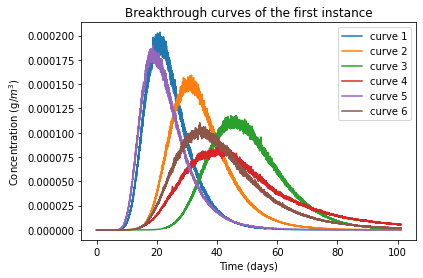

In [3]:
import matplotlib.pyplot as plt

# let's have a look at the first instance
# print(X[0].shape)
# out: (6, 20933, 2)
# 6 is the number of curves (one from each well)
# 20933 is the number of time steps in each curve (varies from instance to instance)
# 2 indicates the time and concentration
for i in range(6):
    plt.plot(X[0][i, :, 0], X[0][i, :, 1], label=f'curve {i+1}')
plt.xlabel('Time (days)')
plt.ylabel('Concentration (g/$m^3$)')
plt.legend()
plt.title('Breakthrough curves of the first instance')

#### Plot the first instance of the target ####

(145, 2)


Text(0.5, 1.0, 'Protection zone of the first instance')

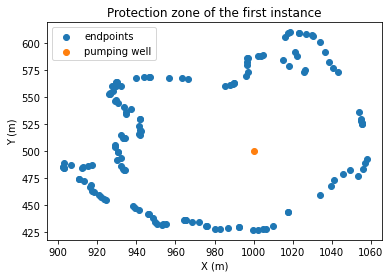

In [4]:
print(y[0].shape)
# out: (145, 2)
# 145 is the number of particles (vertexes)
# 2 indicates X and Y coordinates
# let's have a look at the first instance (scatter plot)
plt.scatter(y[0][:, 0], y[0][:, 1], label='endpoints')
# let's add the pumping well
plt.scatter(1000, 500, label='pumping well')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.legend()
plt.title('Protection zone of the first instance')

## Preprocessing ##

### Preprocessing the predictor ###

In [5]:
from scipy.interpolate import interp1d


def curve_interpolation(tc0, n_time_steps: int = 200, t_max: float = 1.01080e02):
    """
    Perform data transformations on the predictor.
    The breakthrough curves do not share the same time steps.
    We need to save the data array in a consistent shape, thus interpolates and subdivides each simulation curves into n time steps.
    :param tc0: original data - breakthrough curves of shape (n_sim, n_wells, n_time_steps, 2)
    :param n_time_steps: float: desired number of time step, will be the new dimension in shape[1].
    :param t_max: float: Time corresponding to the end of the simulation (default unit is seconds).
    :return: Observation data array with shape (n_sim, n_time_steps, n_wells)
    """
    # Preprocess d
    f1d = []  # List of interpolating functions for each curve
    for t in tc0:
        fs = [interp1d(c[:, 0], c[:, 1], fill_value="extrapolate") for c in t]  # interpolate each curve
        f1d.append(fs)
    f1d = np.array(f1d)
    # n_time_steps = 200  Arbitrary number of time steps to create the final transport array
    ls = np.linspace(0, t_max, num=n_time_steps)
    tc = []  # List of interpolating functions for each curve
    for f in f1d:
        ts = [fi(ls) for fi in f]
        tc.append(ts)
    tc = np.array(tc)  # Data array

    return tc

In [6]:
# let's apply the function to the predictor set
X_interp = curve_interpolation(X)

(6, 200)


Text(0.5, 1.0, 'Breakthrough curves of the first instance after interpolation')

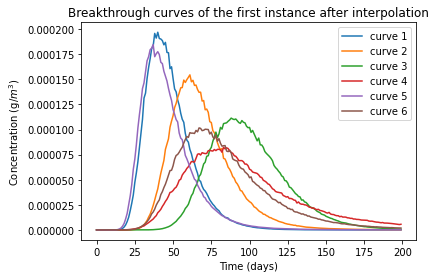

In [7]:
# let's have a look at the first instance of the new predictor
print(X_interp[0].shape)
# out: (6, 200)
# 6 is the number of curves (one from each well)
# 200 is the new number of time steps in each curve
# not that we got rid of the time dimension. We are allowed to do so as the whole set is now interpolated over the same time steps.
for i in range(6):
    plt.plot(X_interp[0][i, :], label=f'curve {i+1}')
plt.xlabel('Time (days)')
plt.ylabel('Concentration (g/$m^3$)')
plt.legend()
plt.title('Breakthrough curves of the first instance after interpolation')
# Observe that the curves are now interpolated over the same time steps and the time dimension is gone.
# We also got rid of some noise in the data.

Finally, we concatenate the 6 curves into a single array of shape (n_sim, 6*200). Feel free to try with different combinations.

In [8]:
# let's concatenate the 6 curves into a single array of shape (n_sim, 6*200)
X_interp = X_interp.reshape(-1, 6*200)

(4148, 1200)


Text(0.5, 1.0, 'Breakthrough curves of the first instance after concatenation')

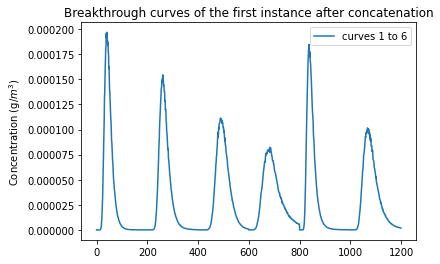

In [9]:
# let's have a look at the first instance of the new predictor
print(X_interp.shape)
# out: (6*200,)
# 6*200 is the new number of time steps in each curve
plt.plot(X_interp[0], label='curves 1 to 6')
plt.ylabel('Concentration (g/$m^3$)')
plt.legend()
plt.title('Breakthrough curves of the first instance after concatenation')

### Preprocessing the target ###
Preprocessing the target is a bit more complicated as we have to deal with the fact that the target is a set of endpoints.

It does not really make sense to try to predict the 2D position of the endpoints, as the 2D position is not a continuous function.

Instead, we need to find a way to represent the endpoints as a continuous function.

The endpoints have already been linked together using the Traveling Salesman Problem to form the delineation of the protection zone. We used Google's OR-Tools library. We can use those paths to create a continuous function with the Signed Distance Function.

Let's first define our functions.

In [10]:
import skfmm

from matplotlib.patches import Polygon

from skbel.spatial import block_shaped

def binary_polygon(
    xys: np.array,
    nrow: int,
    ncol: int,
    pzs: np.array,
    outside: float = -1,
    inside: float = 1,
) -> np.array:
    """
    Given a polygon whose vertices are given by the array pzs, and a matrix of
    centroids coordinates of the surface discretization, assigns to the matrix a certain value
    whether the cell is inside or outside said polygon.
    To compute the signed distance function, we need a negative/positive value.
    :param xys: Centroids of a grid' cells
    :param nrow: Number of rows
    :param ncol: Number of columns
    :param pzs: Array of ordered vertices coordinates of a polygon.
    :param pzs: Polygon vertices (v, 2)
    :param outside: Value to assign to the matrix outside the polygon
    :param inside: Value to assign to the matrix inside the polygon
    :return: phi = the binary matrix
    """

    # Creates a Polygon abject out of the polygon vertices in pzs
    poly = Polygon(pzs, True)
    # Checks which points are enclosed by polygon.
    ind = np.nonzero(poly.contains_points(xys))[0]
    phi = np.ones((nrow, ncol)) * outside  # SD - create matrix of 'outside'
    phi = phi.reshape((nrow * ncol))  # Flatten to have same dimension as 'ind'
    phi[ind] = inside  # Points inside the WHPA are assigned a value of 'inside'
    phi = phi.reshape((nrow, ncol))  # Reshape

    return phi

def h_sub(h: np.array, un: int, uc: int, sc: int) -> np.array:
    """
    Process signed distance array.
    :param h: Signed distance array
    :param un: number of rows
    :param uc: number of columns
    :param sc: New cell dimension in x and y direction (original is 1)
    :return: New signed distance array
    """
    h_u = np.zeros((h.shape[0], un, uc))
    for p in range(h.shape[0]):
        sim = h[p]
        sub = block_shaped(arr=sim, nrows=sc, ncols=sc)
        h_u[p] = np.array([s.mean() for s in sub]).reshape(un, uc)
    return h_u


def signed_distance(xys: np.array, nrow: int, ncol: int, grf: float, pzs: np.array):
    """
    Given an array of coordinates of polygon vertices, computes its signed distance field.
    :param xys: Centroids of a grid' cells
    :param nrow: Number of rows
    :param ncol: Number of columns
    :param grf: Grid dimension (uniform grid)
    :param pzs: Array of ordered vertices coordinates of a polygon.
    :return: Signed distance matrix
    """
    phi = binary_polygon(xys, nrow, ncol, pzs) # phi is a binary matrix
    sd = skfmm.distance(phi, dx=grf)  # Signed distance computation
    return sd


That's a lot of processing. Let's now apply it to our data.

In [11]:
from skbel.spatial import grid_parameters

# First, we need to define the grid parameters
# Geometry of the focused area on the main grid, enclosing all wells, as to reduce computation time
x_range = [800, 1150]  # x-range (m)
y_range = [300, 700]  # y-range (m)
# Defines cell dimensions for the signed distance computation.
cell_dim = 4  # Cell dimension (m)

xys, nrow, ncol = grid_parameters(
    x_lim=x_range, y_lim=y_range, grf=cell_dim
)
# xys: Centroids of a grid' cells
# nrow: Number of rows
# ncol: Number of columns

# Compute signed distance on pzs.
# h is the matrix of target feature on which PCA will be performed.
y_sd = np.array(
    [signed_distance(xys, nrow, ncol, cell_dim, pp) for pp in y]
)

# It is important to note that the shape of the matrix is (ncol, nrow) = (87, 100)
# For training purposes, we will flatten the matrix to have a vector of shape (n_sim, 87*100)
y_sd_flat = y_sd.reshape((y_sd.shape[0], nrow * ncol))
print(y_sd_flat.shape)

(4148, 8700)


Let's examine the transformed target `y_sd`.

Each instance is now a matrix of signed distance values.

(100, 87)


Text(0.5, 1.0, 'Signed distance field of the first instance')

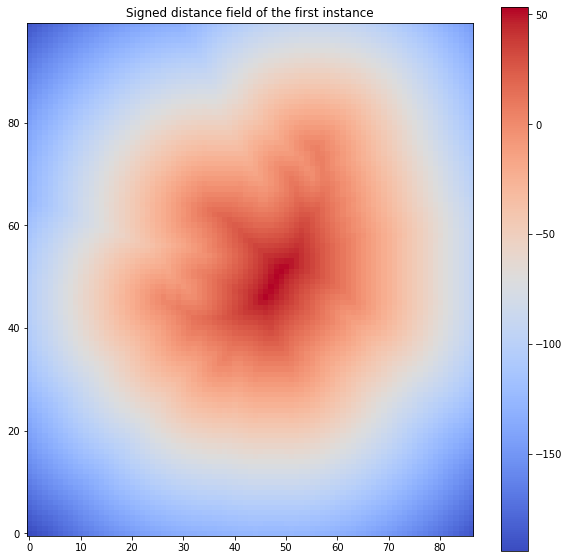

In [12]:
print(y_sd[0].shape)
# out: (100, 87) = (nrow, ncol)
# Let's plot the first instance
plt.figure(figsize=(10, 10))
plt.imshow(y_sd[0], cmap="coolwarm", origin="lower")
plt.colorbar()
plt.title("Signed distance field of the first instance")

Can you recognize the shape of the target?

Let's plot the first instance in 2D on top of the grid.

The target is now represented as the 0 contour of the signed distance field.

Text(0.5, 1.0, 'Signed distance field of the first instance')

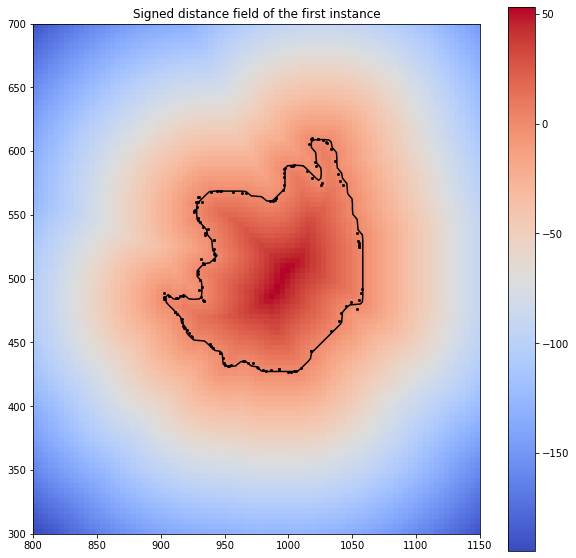

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(y_sd[0], cmap="coolwarm", origin="lower", extent=[x_range[0], x_range[1], y_range[0], y_range[1]])  # Plot the signed distance field over the grid
plt.colorbar()
plt.plot(y[0][:, 0], y[0][:, 1], "ko", markersize=2)  # plot the original endpoints
plt.contour(y_sd[0], levels=[0], colors="black", extent=[x_range[0], x_range[1], y_range[0], y_range[1]])  # plot the 0 contour of the signed distance field
plt.title("Signed distance field of the first instance")

## Training the model ##
This is where you should start being creative. You can of course go back to an earlier stage and choose a different preprocessing method.

You can try different models, different hyperparameters, different preprocessing, etc.

The following will be the application of our Bayesian Evidential Learning framework as described in the paper. The framework is described in more detail in the paper.

Here's a quick overview of the framework.
1. Preprocess the data
2. Apply dimensionality reduction (PCA)
3. Train the model with Canonical Correlation Analysis (CCA)
4. Apply the model to the test data
5. Evaluate the performance of the model
6. Repeat the process for different models and hyperparameters

It is important to note that as a bayesian method, we do not predict one single value, but rather the posterior distribution of the target given the observed data. We can then sample as many times as we want from the posterior distribution to obtain our predictions.

The steps are illustrated in the following figure.

![BEL](https://raw.githubusercontent.com/robinthibaut/kaggle/master/whpa/datasets/belf.png)

In [14]:
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from skbel import BEL

# Pipeline before CCA
X_pre_processing = Pipeline(
    [
        ("scaler", StandardScaler(with_mean=False)),
        ("pca", PCA(n_components=50)),
        ("scaler2", StandardScaler(with_mean=False)),
    ]
)
Y_pre_processing = Pipeline(
    [
        ("scaler", StandardScaler(with_mean=False)),
        ("pca", PCA(n_components=30)),
        ("scaler2", StandardScaler(with_mean=False)),
    ]
)

# Canonical Correlation Analysis
cca = CCA(n_components=30)


# Initiate BEL object
model = BEL(
    X_pre_processing=X_pre_processing,
    Y_pre_processing=Y_pre_processing,
    cca=cca,
)

Let's first split the data into training and test sets.

We will use the first 80% of the data for training and the remaining 20% for testing.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_interp, y_sd_flat, test_size=0.2, random_state=42)

In [16]:
# Set model parameters
model.random_state = 42  # Random state
# Save original dimensions of both predictor and target
model.Y_shape = (100, 87)  # 100 rows and 87 columns
# Number of samples to be extracted from the posterior distribution
model.n_posts = 500

Train the model

In [17]:
# Fit BEL model
model.fit(X=X_train, Y=y_train)

BEL(X_post_processing=Pipeline(steps=[('nothing', 'passthrough')]),
    X_pre_processing=Pipeline(steps=[('scaler',
                                      StandardScaler(with_mean=False)),
                                     ('pca', PCA(n_components=50)),
                                     ('scaler2',
                                      StandardScaler(with_mean=False))]),
    Y_post_processing=Pipeline(steps=[('nothing', 'passthrough')]),
    Y_pre_processing=Pipeline(steps=[('scaler',
                                      StandardScaler(with_mean=False)),
                                     ('pca', PCA(n_components=30)),
                                     ('scaler2',
                                      StandardScaler(with_mean=False))]),
    cca=CCA(n_components=30), random_state=42)

In [18]:
X_test[0].shape

(1200,)

In [19]:
# The posterior distribution is computed within the method below.
# Let's only predict the first instance (index 0)
n_obs = 0
y_predicted = model.predict(X_test[n_obs])
print(y_predicted.shape)
# out: (1, n_posts, 8700)
# For one example, we sampled 400 posterior samples from the model and backtransformed them to the original space.

(1, 500, 8700)


Let's visualize the results.

Text(0.5, 1.0, 'Prior, predicted and true WHPA')

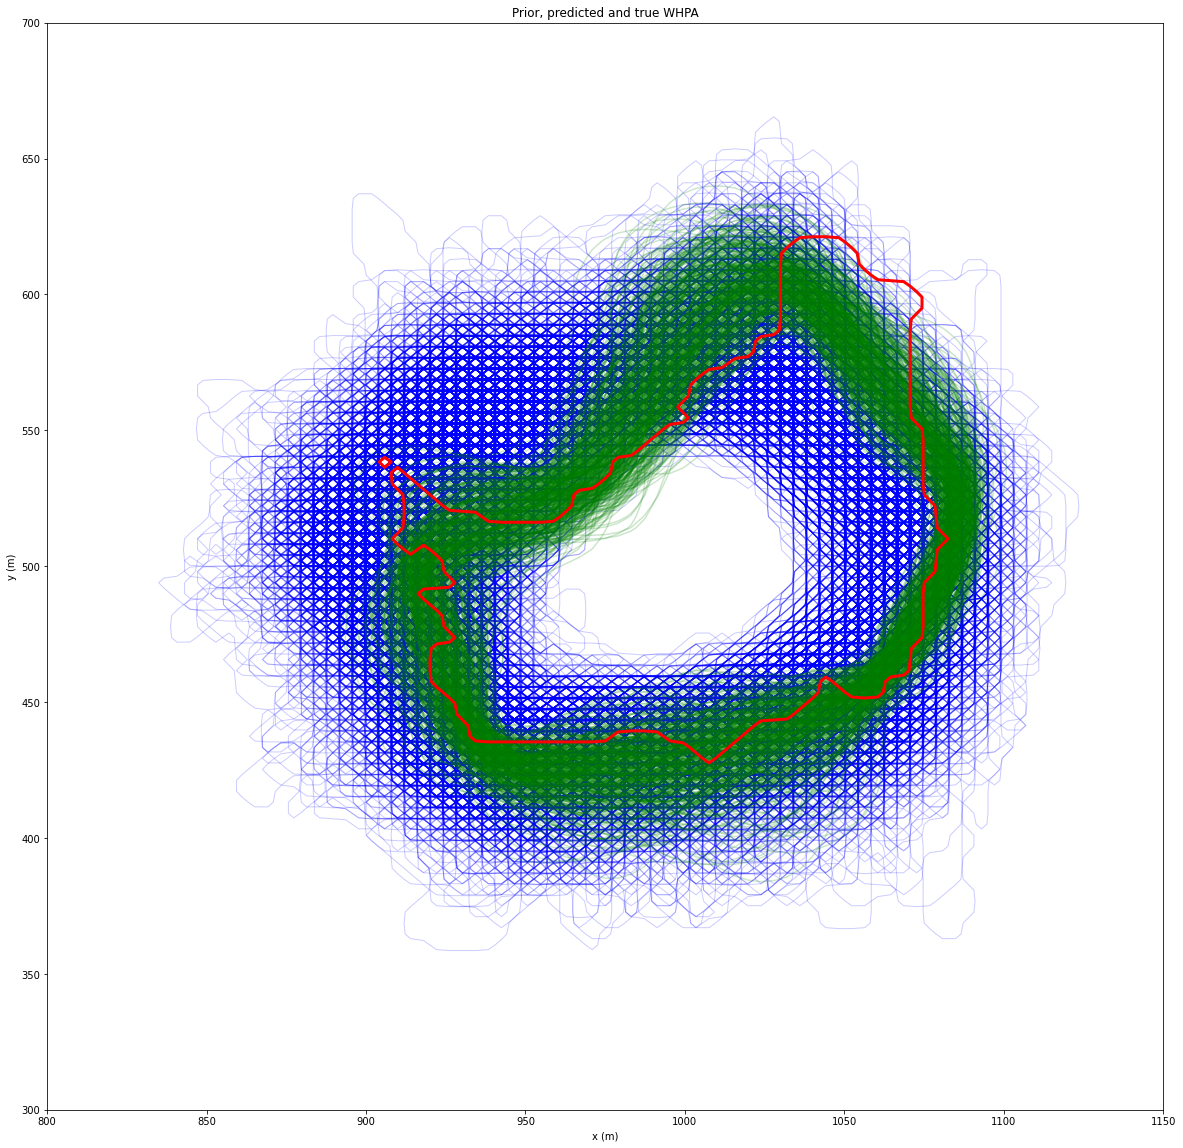

In [20]:
# Plot the predicted WHPAs (O contour of the signed distance fields)
plt.figure(figsize=(20, 20))
# plot the training set in the background
for pct in y_train:
    plt.contour(pct.reshape(model.Y_shape), levels=[0], alpha=.2, colors="blue", linewidths=1, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
# plot the predicted WHPAs
for pc in y_predicted[0]:
    pcr = np.reshape(pc, model.Y_shape)
    plt.contour(pcr, levels=[0], colors="green", alpha=.2, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])  # plot the 0 contour of the signed distance field
# Plot the true WHPA
plt.contour(y_test[n_obs].reshape(model.Y_shape), levels=[0], colors="red", alpha=1, linewidths=3,extent=[x_range[0], x_range[1], y_range[0], y_range[1]])  # plot the 0 contour of the true signed distance field
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Prior, predicted and true WHPA")